# Using "Cleaned" Data
In this notebook, we will start with a dataframe as follows:
* drop duplicates (26 records)
* drop columns with missing values (7 columns)
    * funder
    * installer
    * subvillage
    * public_meeting
    * scheme_management
    * scheme_name
    * permit
* drop rows with zero values for certain features (22,783 records)
    * longitude
    * construction_year
    * population
    * gps_height

The result has 36,581 records (reduced from 59,400) and omits the 7 features noted above. This leaves ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
SEED = 10

In [2]:
# load the data from two files
dfX = pd.read_csv('../data/training_set_values.csv')
dfy = pd.read_csv('../data/training_set_labels.csv')
# concatenate the files
df = pd.concat([dfX, dfy['status_group']], axis = 1)
# show rows and columns
df.shape

(59400, 41)

In [3]:
# drop the duplicate records
df.drop(df[df.duplicated(subset=df.columns.difference(['id']))].index, inplace=True)
# show rows and columns
df.shape

(59364, 41)

In [4]:
# drop all columns with missing values
df.dropna(axis='columns', inplace=True)
# show rows and columns
df.shape

(59364, 34)

In [5]:
# drop all records with seemingly erroneous zero values
df.drop(df[(df.longitude == 0) | (df.construction_year == 0) | \
           (df.population == 0) | (df.gps_height == 0)].index, inplace=True)
# show rows and columns
df.shape

(36581, 34)

In [6]:
# encode the status_group as 1s ('functional') and 0s ('non functional' or 'functional needs repair')
df.status_group = df.status_group.apply(lambda x: 1 if x == 'functional' else 0)
# convert date_recorded to datetime object
df.date_recorded = pd.to_datetime(df.date_recorded, format = "%Y-%m-%d")

# Building Trees Using scikit-learn
This model follows the steps of lab 26.06.

The input is as specified at the beginning of the document, and from those features only the numerical ones are used. This includes:
* amount_tsh
* gps_height
* longitude
* latitude
* num_private
* region_code
* district_code
* population
* construction_year

In [7]:
# create X and y
X = df.select_dtypes(include=['number']).drop(['id', 'status_group'], axis=1)
y = df.status_group

In [8]:
# Perform an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

In [9]:
# Train a DT classifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state=SEED)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [10]:
# Make predictions for test data
y_pred = classifier.predict(X_test)

In [11]:
# Calculate accuracy
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy is: {0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is: 72.92606259395927

AUC is: 0.73

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,2288,972,3260
1,1009,3048,4057
All,3297,4020,7317


In [12]:
(y_test == 1).sum() / (y_test).size

0.5544622112887796

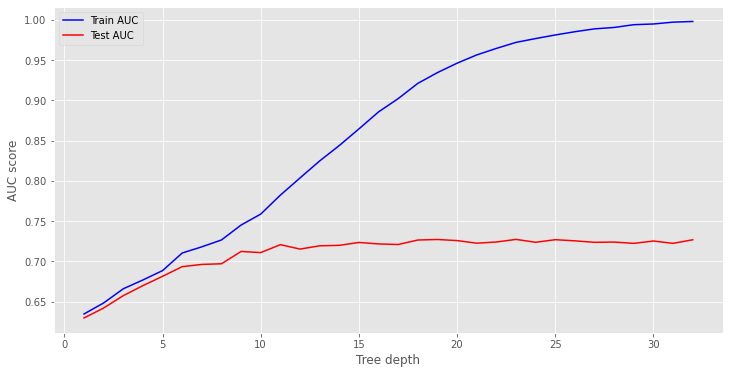

In [13]:
# Identify the optimal tree depth for given data
max_depths = list(range(1, 33))
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

Stop at depth = 11?

Stop at depth = 6?

Stop at depth = 9?